<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : 
### Student Number : 
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [4]:
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
                ])

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [5]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [6]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################

train_loader = torch.utils.data.DataLoader(train_data, batch_size=16,
                                          shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(valid_data, batch_size=16,
                                         shuffle=False, num_workers=2)

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1gQzafyxTkuvQr8T-xUncLmedX94LnY_l/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [7]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
class ResidualClassifier(nn.Module):
    def __init__(self):
        super(ResidualClassifier, self).__init__()
   
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

       
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=2)
     
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv5= nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.avgpool= nn.AdaptiveAvgPool2d(1)
        self.flatten= nn.Flatten()
        self.fc1 =nn.Linear(64,10)
        
        self.relu = nn.ReLU(inplace=True)
       

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        residual1=out

        out = self.conv2(out)
        out = self.relu(out)
        out = self.conv3(out)

      
        out = self.relu(out)
        out = out + residual1
        out = self.maxpool(out)
        out = self.conv4(out)
        out = self.relu(out)
        residual2 = out
        out = self.conv5(out)
        out = self.relu(out)
        out = self.conv5(out)
        out = self.relu(out)
        out = out + residual2
        out = self.avgpool(out)
        out = self.flatten(out)
        out = self.fc1(out)
        

        

        return out




# Train Model (30 Points)

In [8]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
######################################################################
model = ResidualClassifier().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)  

# optimizer = torch.optim.Adam(model.parameters(),0.001)
criterion = torch.nn.CrossEntropyLoss()

In [9]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################

######################################################################
##        Train your model (Complete the code below)                ##
######################################################################
total_step = len(train_loader)
num_epochs = 20
val_loss_lst = []
val_acc_lst = []
train_loss_lst = []
train_acc_lst = []
def test(model, loader, f_loss, device):
    model.eval()
    Number = 0
    tot_loss, correct = 0.0, 0.0
    for i, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        Number += images.shape[0]
        tot_loss += images.shape[0] * f_loss(outputs, labels).item()
        predicted_labels = outputs.argmax(dim=1)
        correct += (predicted_labels == labels).sum().item()
    return tot_loss/Number, correct/Number
def train(model, loader, optimizer, device):
   
    
        model.train()
        for images, labels in train_loader:  
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

for epoch in range(num_epochs):
    
    train(model, train_loader , optimizer, device)
    with torch.no_grad():
        val_loss, val_acc = test(model, val_loader, criterion, device)
        train_loss, train_acc = test(model, train_loader, criterion, device)
        val_loss_lst.append(val_loss)
        val_acc_lst.append(val_acc)
        train_loss_lst.append(train_loss)
        train_acc_lst.append(train_acc)
        print(" Training : Loss : {:.4f}, Acc : {:.4f}".format(train_loss, train_acc))
        print(" Validation : Loss : {:.4f}, Acc : {:.4f}".format(val_loss, val_acc))

            

 Training : Loss : 0.1072, Acc : 0.9678
 Validation : Loss : 0.1223, Acc : 0.9626
 Training : Loss : 0.0601, Acc : 0.9821
 Validation : Loss : 0.0825, Acc : 0.9771
 Training : Loss : 0.0397, Acc : 0.9882
 Validation : Loss : 0.0518, Acc : 0.9837


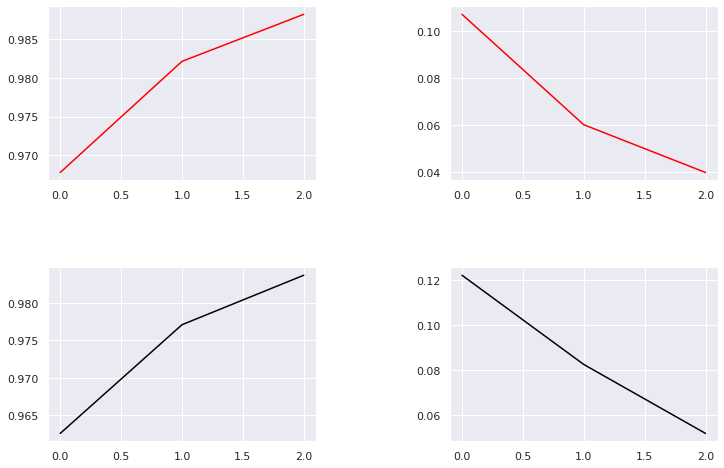

In [10]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
import seaborn as sn

sn.set()
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

sn.lineplot(data=train_acc_lst, ax=axes[0, 0], color='red');

sn.lineplot(data=train_loss_lst, ax=axes[0, 1], color='red');
sn.lineplot(data=val_acc_lst, ax=axes[1, 0], color='black');
sn.lineplot(data=val_loss_lst, ax=axes[1, 1], color='black');


# Test Model (20 Points)

10000


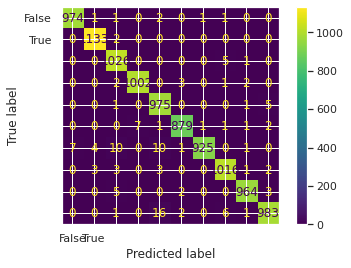

Accuracy of the network on the test images: 98.77 %


In [11]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics




test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))
predicted_target = []
targets_lst = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_target.append(outputs.argmax(dim=1))
        targets_lst.append(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs
    predicted_target = torch.cat(predicted_target, dim=0)
    targets_lst = torch.cat(targets_lst, dim=0)
    confusion_matrix = metrics.confusion_matrix(targets_lst, predicted_target)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display.plot()
    plt.show()
    print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))   